Problem 16: По описанию условий посева предсказать прорастут семена растений или нет. Провести бинарную классификацию семян с помощью метода Парзеновского окна. Построить график зависимости ошибки на контроле от ширины окна. Подобрать оптимальную ширину окна.

In [208]:
#импортируем нужные модули
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cross_validation
from sklearn import neighbors
from sklearn import metrics

In [209]:
#Обрабатываем данные, создаем переменную с тренировочными данными: входы и цели
upper_row = ['Season','Age','Diseases','Traumas','Surguries','Fevers','Alcohol_Consumption','Smoking','Sitting_time','Output']
dataframe  = pd.read_csv('fertility_Diagnosis.txt',names = upper_row ,sep = ',');
Targets = dataframe['Output']
Inputs = dataframe[['Season','Age','Diseases','Traumas','Surguries','Fevers','Alcohol_Consumption','Smoking','Sitting_time']]

dataframe.head()

,Season,Age,Diseases,Traumas,Surguries,Fevers,Alcohol_Consumption,Smoking,Sitting_time,Output
0,-0.33,0.69,0,1,1,0,0.8,0,0.88,N
1,-0.33,0.94,1,0,1,0,0.8,1,0.31,O
2,-0.33,0.50,1,0,0,0,1.0,-1,0.50,N
3,-0.33,0.75,0,1,1,0,1.0,-1,0.38,N
4,-0.33,0.67,1,1,0,0,0.8,-1,0.50,O


In [ ]:
dataframe_withoutseason = dataframe[['Age','Diseases','Traumas','Surguries','Fevers','Alcohol_Consumption','Smoking','Sitting_time','Output']]
dataframe_withoutage = dataframe[['Season','Diseases','Traumas','Surguries','Fevers','Alcohol_Consumption','Smoking','Sitting_time','Output']]
dataframe_withoutdisease = dataframe[['Age','Season','Traumas','Surguries','Fevers','Alcohol_Consumption','Smoking','Sitting_time','Output']]
dataframe_withouttraumas = dataframe[['Age','Season','Diseases','Surguries','Fevers','Alcohol_Consumption','Smoking','Sitting_time','Output']]


In [210]:
#проводим перемешивание данных для тренировки классификатора и проверки работы
Inputs_train, Inputs_test, Targets_train, Targets_test = cross_validation.train_test_split(dataframe.loc[:, dataframe.columns != 'Output'], dataframe['Output'], test_size=0.2)

In [13]:

Inputs_test.index[:]

Int64Index([32, 70, 4, 90, 63, 17, 77, 64, 23, 11, 88, 3, 73, 56, 95, 59, 12,
            8, 46, 68],
           dtype='int64')

In [139]:
Inputs_train.drop(Inputs_train.loc[[1, 2, 3, 5, 16, 18]])
Targets_train.drop(Targets_train.loc[[1, 2, 3, 5, 16, 18]])
Inputs_test.drop(Inputs_test.loc[[4,19]])
Targets_test.drop(Targets_test.loc[[4,19]])

ValueError: labels ['Season' 'Age' 'Diseases' 'Traumas' 'Surguries' 'Fevers'
 'Alcohol_Consumption' 'Smoking' 'Sitting_time'] not contained in axis

In [21]:
neighbor = neighbors.RadiusNeighborsClassifier(radius = 3.0,weights = 'distance',metric='euclidean' ,algorithm = 'auto')
neighbor.fit(Inputs_train,Targets_train)
predictions = neighbor.predict(Inputs_test)
accuracy = metrics.accuracy_score(Targets_test, predictions)
accuracy

0.80000000000000004

In [22]:
#экспериментально определяем, что для большинства выборок радиус классификатора менее 2.0 не находит 
#для некоторых элементов соседей, соответственно, обрывая работу алгоритма. Экспериментально пробуя изменять 
#шаг радиуса, понимаем, что точность алгоритма меняется при шаге ~0.1 наглядно
accuracy_arr = []
a = np.linspace(2.0,3.5,10)
for i in a:
    neighbor = neighbors.RadiusNeighborsClassifier(radius = int(i),weights = 'distance',metric='euclidean' ,algorithm = 'auto')
    neighbor.fit(Inputs_train,Targets_train)
    predictions = neighbor.predict(Inputs_test)
    accuracy = metrics.accuracy_score(Targets_test, predictions)
    accuracy_arr.append(accuracy)
    

In [23]:
accuracy_arr

[0.80000000000000004,
 0.80000000000000004,
 0.80000000000000004,
 0.80000000000000004,
 0.80000000000000004,
 0.80000000000000004,
 0.80000000000000004,
 0.80000000000000004,
 0.80000000000000004,
 0.80000000000000004]

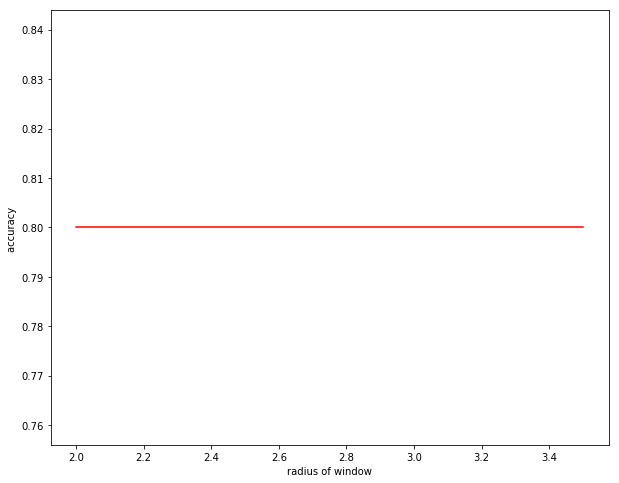

In [24]:
x = np.linspace(2,3.5,10)
plt.figure(figsize=(10, 8))
plt.plot(x, accuracy_arr, color='r')
plt.ylabel('accuracy ')
plt.xlabel('radius of window')
plt.show()


# Оптимальный радиус окна Парзена - 2.9 

In [211]:
#для примера покажем аналогичную работу классификатора ближайших соседей для этих же данных
accuracy_arr_2 = []

for k in range(1,6):
    neighbor = neighbors.KNeighborsClassifier(n_neighbors = k)
    neighbor.fit(Inputs_train,Targets_train)
    predictions = neighbor.predict(Inputs_test)
    accuracy = metrics.accuracy_score(Targets_test, predictions)
    accuracy_arr_2.append(accuracy)
accuracy_arr_2

[0.80000000000000004,
 0.94999999999999996,
 0.94999999999999996,
 0.94999999999999996,
 0.94999999999999996]

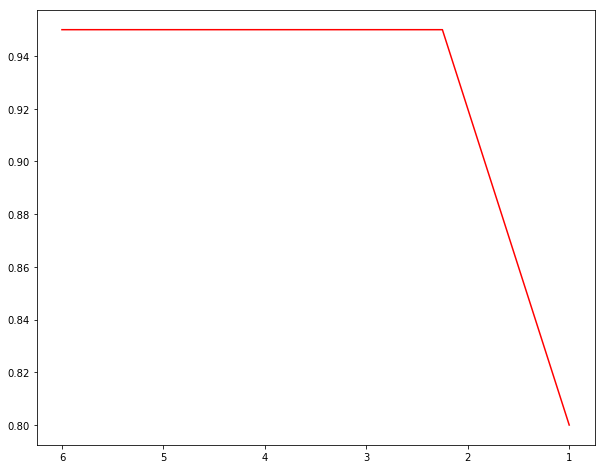

In [213]:
x = np.linspace(1,6,5)
plt.figure(figsize=(10, 8))
plt.plot(x, accuracy_arr_2, color='r')
plt.show()

In [14]:
weights = neighbor.weights
weights

'distance'

0.80000000000000004

# Задача 3 - построение графика зависимости средней ошибки(точности) в зависимости от сложности данных

сюда будем записывать данные об ошибках и средних отклонений для последующего вывода на график

In [149]:
Errors_test = []
Errors_train = []
Mean_dev_tests = []
Mean_dev_trains = []

 Сперва сделаем модель для вычисления средней ошибки на тренировочных и тестовых данных. k - количество проходов алгоритма(кросс-валидация, расчет) по данным. 

In [183]:
Error_train = 0
Error_test = 0
Mean_deviation_test = 0
Mean_deviation_train = 0
k = 40
for i in range(k):
    Inputs_train, Inputs_test, Targets_train, Targets_test = cross_validation.train_test_split(dataframe.loc[:, ['Alcohol_Consumption']], dataframe['Output'], test_size=0.5)
    #['Season','Age','Diseases','Traumas','Surguries','Fevers','Alcohol_Consumption','Smoking','Sitting_time'] - так должна выглядеть базовая выборка по столбцам 
    accuracy_arr = []
    accuracy_arr_2 = []
    a = np.linspace(2.0,3.5,10)
    for i in a:
        neighbor = neighbors.RadiusNeighborsClassifier(radius = int(i),weights = 'distance',metric='euclidean' ,algorithm = 'auto')
        neighbor.fit(Inputs_train,Targets_train)
        predictions = neighbor.predict(Inputs_test)
        predictions2 = neighbor.predict(Inputs_train)
        accuracy = metrics.accuracy_score(Targets_test, predictions)
        accuracy2 = metrics.accuracy_score(Targets_train, predictions)
        accuracy_arr.append(accuracy)
        accuracy_arr_2.append(accuracy2)
    Error_test += max(accuracy_arr)
    Error_train += max(accuracy_arr_2)
    Mean_deviation_test += (0.875 - max(accuracy_arr))**2
    Mean_deviation_train += (0.87 - max(accuracy_arr_2))**2
    
Error_test = Error_test/k
Error_train = Error_train/k
Mean_deviation_test = (Mean_deviation_test**(1/2))/(k-1)
Mean_deviation_train = (Mean_deviation_train**(1/2))/(k-1)

print(Error_test,' ',Error_train,'',Mean_deviation_test,' ',Mean_deviation_train)
    

0.8695   0.8905  0.00505069630861   0.00598046348189


сюда записывать данные после каждого уменьшения(ручного) сложности данных. 
Делается это удалением названия столбца в предыдущей ячейке в 7-ой строке.

In [184]:
Errors_test.append(Error_test)     
Errors_train.append(Error_train)
Mean_dev_tests.append(Mean_deviation_test)
Mean_dev_trains.append(Mean_deviation_train)

In [186]:
Errors_test

[0.87549999999999994,
 0.87850000000000006,
 0.88000000000000023,
 0.88099999999999989,
 0.8600000000000001,
 0.86300000000000021,
 0.88899999999999968,
 0.88249999999999995,
 0.86949999999999983]

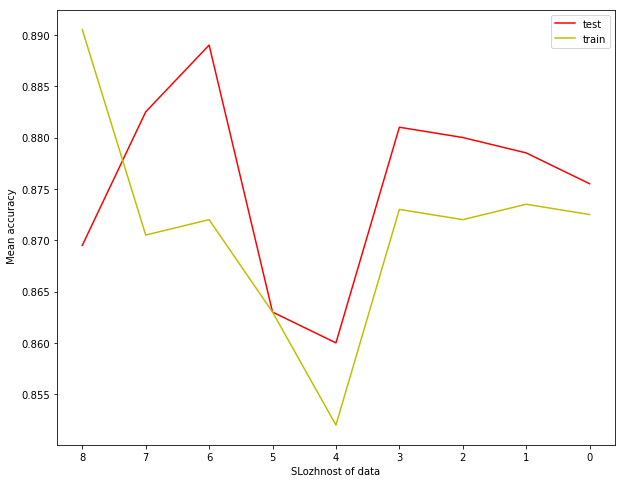

In [218]:
x = np.linspace(0,8,9)
plt.figure(figsize=(10, 8))
plt.plot(x, Errors_test, color='r',label = 'test')
plt.plot(x, Errors_train, color='y',label = 'train')
plt.gca().invert_xaxis()
plt.ylabel(' Mean accuracy')
plt.xlabel('SLozhnost of data')

plt.legend()
plt.show()

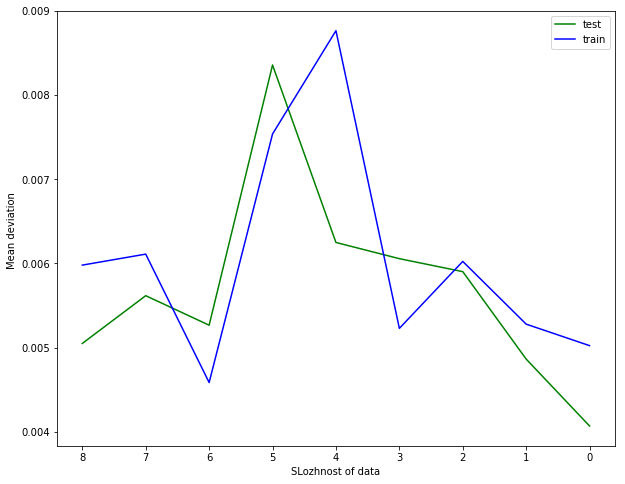

In [217]:
x = np.linspace(0,8,9)
plt.figure(figsize=(10, 8))
plt.plot(x, Mean_dev_tests, color='g',label = 'test')
plt.plot(x, Mean_dev_trains, color='b',label = 'train')
plt.gca().invert_xaxis()
plt.ylabel('Mean deviation ')
plt.xlabel('SLozhnost of data')
plt.legend()
plt.show()
